In [1]:
%%time
import numpy as np
import lightgbm as lgb

from functions import *
from datetime import datetime
from sklearn.model_selection import train_test_split

np.random.seed(0)

first_test_day = 1914
sales, prices, calendar, summary, encoder = prepare_data(first_test_day)

CPU times: user 19 s, sys: 2.4 s, total: 21.4 s
Wall time: 22.7 s


In [2]:
# check whether value is qty and rename if yes

# choose level: day or week
# choose lags and statistics (mean, std, median, etc)
# choose length of history
# add features: store_id, price, promo, etc
# scaling of qty?
# choose model
# train model
# submit prediction

# retro experiments: error calculation and convenient config

# Q1: which is better - daily forecast or weekly with (clever) disaggregation to days (at the lowest level)?
# Q2: is label encoding id's the only way? maybe some TE? probably better to search kaggle notebooks for the answer

# TBD: sumbit daily forecast with all available features by lgbm

In [3]:
%%time
# aggregate sales to weekly data
sales = sales.groupby(['id', pd.Grouper(key='date', freq='W-SAT', label='left')]).sum().reset_index().sort_values(['id','date'])
sales

CPU times: user 12.8 s, sys: 4.1 s, total: 16.9 s
Wall time: 18.8 s


,id,date,qty
0,0,2011-01-22,3
1,0,2011-01-29,9
2,0,2011-02-05,7
3,0,2011-02-12,8
4,0,2011-02-19,14
...,...,...,...
8506705,30489,2016-04-23,0
8506706,30489,2016-04-30,0
8506707,30489,2016-05-07,0
8506708,30489,2016-05-14,0


In [4]:
# prices are already given at weekly level

In [5]:
# aggregate calendar to weekly data
event_names = set()
for i in [1,2]:
    tmp = calendar[f'event_name_{i}']
    tmp = tmp.dropna()
    tmp = tmp.unique()
    tmp = set(tmp)
    event_names = event_names.union(tmp)
event_names = list(event_names)
event_names = sorted(event_names)

event_types = set()
for i in [1,2]:
    tmp = calendar[f'event_type_{i}']
    tmp = tmp.dropna()
    tmp = tmp.unique()
    tmp = set(tmp)
    event_types = event_types.union(tmp)
event_types = list(event_types)
event_types = sorted(event_types)

calendar_weekly = calendar.copy()

# for event_name in event_names:
#     calendar_weekly[f"flg_name_{event_name}"] = 0 + (calendar_weekly['event_name_1'] == event_name) + (calendar_weekly['event_name_2'] == event_name)
for event_type in event_types:
    calendar_weekly[f"flg_type_{event_type}"] = 0 + (calendar_weekly['event_type_1'] == event_type) + (calendar_weekly['event_type_2'] == event_type)
    
calendar_weekly.drop(['event_name_1', 'event_name_2', 'event_type_1', 'event_type_2','year','month','wday','weekday','d','date'], axis=1, inplace=True)
calendar_weekly = calendar_weekly.groupby('wm_yr_wk').sum()

calendar_weekly = calendar_weekly.join(calendar[calendar['wday'] == 1][['date', 'wm_yr_wk', 'month', 'year']].set_index('wm_yr_wk')).reset_index().set_index('date')

# reduce memory usage
columns = list(calendar_weekly.columns)
columns.remove('wm_yr_wk')
columns.remove('year')
for column in columns:
    calendar_weekly[column] = calendar_weekly[column].astype('uint8')

calendar_weekly

,wm_yr_wk,snap_CA,snap_TX,snap_WI,flg_type_Cultural,flg_type_National,flg_type_Religious,flg_type_Sporting,month,year
date,,,,,,,,,,
2011-01-29,11101,4,2,2,0,0,0,0,1,2011
2011-02-05,11102,6,5,5,0,0,0,1,2,2011
2011-02-12,11103,0,3,3,1,0,0,0,2,2011
2011-02-19,11104,0,0,0,0,1,0,0,2,2011
2011-02-26,11105,4,2,2,0,0,0,0,2,2011
...,...,...,...,...,...,...,...,...,...,...
2016-05-21,11617,0,0,0,0,0,0,0,5,2016
2016-05-28,11618,3,2,2,0,1,0,1,5,2016
2016-06-04,11619,7,4,4,0,0,1,0,6,2016


In [6]:
%%time
# calculated date of the first sale and add it to summary and sales

firstbuy = sales[sales['qty']!=0].groupby('id')[['date']].min()
firstbuy.rename(columns={'date':'firstbuy_date'}, inplace=True)
if 'firstbuy_date' not in summary.columns:
    summary = summary.join(firstbuy, on='id', how='left')
if 'firstbuy_date' not in sales.columns:
    sales = sales.join(firstbuy, on='id', how='left')
del firstbuy

CPU times: user 762 ms, sys: 191 ms, total: 953 ms
Wall time: 995 ms


In [7]:
%%time
# remove starting zeroes for every TS

print(sales.shape)
sales = sales[sales['date'] >= sales['firstbuy_date']]
print(sales.shape)

(8506710, 4)
(6726927, 4)
CPU times: user 241 ms, sys: 96 ms, total: 337 ms
Wall time: 336 ms


In [8]:
%%time
# add desired lags and remove rows with NA's
lags = [5, 6, 7, 8, 9, 52]
lags = np.array(lags)
dataframes = []
for lag in lags:
    sales[f'lag{lag}'] = sales['qty'].shift(lag).fillna(0).astype('uint16')
sales = sales[sales['date'] >= sales['firstbuy_date'] + pd.DateOffset(weeks=lags.max())]
sales

CPU times: user 3.03 s, sys: 337 ms, total: 3.37 s
Wall time: 3.44 s


,id,date,qty,firstbuy_date,lag5,lag6,lag7,lag8,lag9,lag52
52,0,2012-01-21,3,2011-01-22,25,8,11,14,7,3
53,0,2012-01-28,5,2011-01-22,5,25,8,11,14,9
54,0,2012-02-04,6,2011-01-22,5,5,25,8,11,7
55,0,2012-02-11,5,2011-01-22,3,5,5,25,8,8
56,0,2012-02-18,6,2011-01-22,8,3,5,5,25,14
...,...,...,...,...,...,...,...,...,...,...
8506705,30489,2016-04-23,0,2011-01-29,0,1,1,1,0,1
8506706,30489,2016-04-30,0,2011-01-29,0,0,1,1,1,1
8506707,30489,2016-05-07,0,2011-01-29,0,0,0,1,1,0
8506708,30489,2016-05-14,0,2011-01-29,0,0,0,0,1,2


In [9]:
%%time
# add calendar
sales = sales.join(calendar_weekly, on='date')
sales

CPU times: user 580 ms, sys: 144 ms, total: 724 ms
Wall time: 745 ms


,id,date,qty,firstbuy_date,lag5,lag6,lag7,lag8,lag9,lag52,wm_yr_wk,snap_CA,snap_TX,snap_WI,flg_type_Cultural,flg_type_National,flg_type_Religious,flg_type_Sporting,month,year
52,0,2012-01-21,3,2011-01-22,25,8,11,14,7,3,11152,0,0,0,0,0,0,0,1,2012
53,0,2012-01-28,5,2011-01-22,5,25,8,11,14,9,11201,3,2,2,0,0,0,0,1,2012
54,0,2012-02-04,6,2011-01-22,5,5,25,8,11,7,11202,7,4,4,0,0,0,1,2,2012
55,0,2012-02-11,5,2011-01-22,3,5,5,25,8,8,11203,0,4,4,1,0,0,0,2,2012
56,0,2012-02-18,6,2011-01-22,8,3,5,5,25,14,11204,0,0,0,0,1,1,0,2,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8506705,30489,2016-04-23,0,2011-01-29,0,1,1,1,0,1,11613,0,0,0,0,0,0,0,4,2016
8506706,30489,2016-04-30,0,2011-01-29,0,0,1,1,1,1,11614,6,4,4,1,0,2,0,4,2016
8506707,30489,2016-05-07,0,2011-01-29,0,0,0,1,1,0,11615,4,5,4,1,0,0,0,5,2016
8506708,30489,2016-05-14,0,2011-01-29,0,0,0,0,1,2,11616,0,1,2,0,0,0,0,5,2016


In [10]:
%%time
# add summary
sales = sales.join(summary[['id','item_id','dept_id','cat_id','store_id','state_id']].set_index('id'), on='id')
sales

CPU times: user 386 ms, sys: 116 ms, total: 503 ms
Wall time: 503 ms


,id,date,qty,firstbuy_date,lag5,lag6,lag7,lag8,lag9,lag52,...,flg_type_National,flg_type_Religious,flg_type_Sporting,month,year,item_id,dept_id,cat_id,store_id,state_id
52,0,2012-01-21,3,2011-01-22,25,8,11,14,7,3,...,0,0,0,1,2012,0,0,0,0,0
53,0,2012-01-28,5,2011-01-22,5,25,8,11,14,9,...,0,0,0,1,2012,0,0,0,0,0
54,0,2012-02-04,6,2011-01-22,5,5,25,8,11,7,...,0,0,1,2,2012,0,0,0,0,0
55,0,2012-02-11,5,2011-01-22,3,5,5,25,8,8,...,0,0,0,2,2012,0,0,0,0,0
56,0,2012-02-18,6,2011-01-22,8,3,5,5,25,14,...,1,1,0,2,2012,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8506705,30489,2016-04-23,0,2011-01-29,0,1,1,1,0,1,...,0,0,0,4,2016,3048,6,2,9,2
8506706,30489,2016-04-30,0,2011-01-29,0,0,1,1,1,1,...,0,2,0,4,2016,3048,6,2,9,2
8506707,30489,2016-05-07,0,2011-01-29,0,0,0,1,1,0,...,0,0,0,5,2016,3048,6,2,9,2
8506708,30489,2016-05-14,0,2011-01-29,0,0,0,0,1,2,...,0,0,0,5,2016,3048,6,2,9,2


In [11]:
%%time
# add prices
columns = ['store_id', 'item_id', 'wm_yr_wk']
prices.set_index(columns, inplace=True)
sales = sales.join(prices, on = columns)
sales

CPU times: user 2.17 s, sys: 661 ms, total: 2.84 s
Wall time: 2.89 s


,id,date,qty,firstbuy_date,lag5,lag6,lag7,lag8,lag9,lag52,...,flg_type_Religious,flg_type_Sporting,month,year,item_id,dept_id,cat_id,store_id,state_id,sell_price
52,0,2012-01-21,3,2011-01-22,25,8,11,14,7,3,...,0,0,1,2012,0,0,0,0,0,2.00
53,0,2012-01-28,5,2011-01-22,5,25,8,11,14,9,...,0,0,1,2012,0,0,0,0,0,2.00
54,0,2012-02-04,6,2011-01-22,5,5,25,8,11,7,...,0,1,2,2012,0,0,0,0,0,2.00
55,0,2012-02-11,5,2011-01-22,3,5,5,25,8,8,...,0,0,2,2012,0,0,0,0,0,2.00
56,0,2012-02-18,6,2011-01-22,8,3,5,5,25,14,...,1,0,2,2012,0,0,0,0,0,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8506705,30489,2016-04-23,0,2011-01-29,0,1,1,1,0,1,...,0,0,4,2016,3048,6,2,9,2,5.94
8506706,30489,2016-04-30,0,2011-01-29,0,0,1,1,1,1,...,2,0,4,2016,3048,6,2,9,2,5.94
8506707,30489,2016-05-07,0,2011-01-29,0,0,0,1,1,0,...,0,0,5,2016,3048,6,2,9,2,5.94
8506708,30489,2016-05-14,0,2011-01-29,0,0,0,0,1,2,...,0,0,5,2016,3048,6,2,9,2,5.94


In [18]:
%%time
# year, month, maturity (length of history), yearly mean and std
sales['history_length'] = (sales['date'] - sales['firstbuy_date']).dt.days
sales.drop(['firstbuy_date', 'date'], axis=1, inplace=True)

CPU times: user 357 ms, sys: 58.5 ms, total: 416 ms
Wall time: 442 ms


In [19]:
sales

,id,qty,lag5,lag6,lag7,lag8,lag9,lag52,wm_yr_wk,snap_CA,...,flg_type_Sporting,month,year,item_id,dept_id,cat_id,store_id,state_id,sell_price,history_length
52,0,3,25,8,11,14,7,3,11152,0,...,0,1,2012,0,0,0,0,0,2.00,364
53,0,5,5,25,8,11,14,9,11201,3,...,0,1,2012,0,0,0,0,0,2.00,371
54,0,6,5,5,25,8,11,7,11202,7,...,1,2,2012,0,0,0,0,0,2.00,378
55,0,5,3,5,5,25,8,8,11203,0,...,0,2,2012,0,0,0,0,0,2.00,385
56,0,6,8,3,5,5,25,14,11204,0,...,0,2,2012,0,0,0,0,0,2.00,392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8506705,30489,0,0,1,1,1,0,1,11613,0,...,0,4,2016,3048,6,2,9,2,5.94,1911
8506706,30489,0,0,0,1,1,1,1,11614,6,...,0,4,2016,3048,6,2,9,2,5.94,1918
8506707,30489,0,0,0,0,1,1,0,11615,4,...,0,5,2016,3048,6,2,9,2,5.94,1925
8506708,30489,0,0,0,0,0,1,2,11616,0,...,0,5,2016,3048,6,2,9,2,5.94,1932


# abt is ready - time to train model and create prediction

In [20]:
%%time
# from sklearn.ensemble import RandomForestRegressor
first_test_weeknum = calendar[calendar['d'] == f'd_{first_test_day}']['wm_yr_wk'].values[0]

train_idx = sales[sales['wm_yr_wk'] <  first_test_weeknum].index
test_idx = sales[sales['wm_yr_wk'] >=  first_test_weeknum].index

X_test = sales.loc[test_idx, :].drop('qty', axis=1)

X = sales.loc[train_idx, :].drop('qty', axis=1)
y = sales.loc[train_idx, 'qty']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

cat_feats = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ['month']

train_data = lgb.Dataset(X_train, 
                                             label = y_train, 
                                             categorical_feature=cat_feats, 
                                             free_raw_data=False)
fake_valid_data = lgb.Dataset(X_val, 
                                                  label = y_val,
                                                  categorical_feature=cat_feats,
                                                 free_raw_data=False)

CPU times: user 3.6 s, sys: 628 ms, total: 4.23 s
Wall time: 4.36 s


In [21]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
    'seed': 0,
    'n_jobs': 3
}

In [22]:
%%time

model = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 

/home/anton/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/anton/.local/lib/python3.8/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 16.0494
[40]	valid_0's rmse: 13.2312
[60]	valid_0's rmse: 12.4842
[80]	valid_0's rmse: 12.214
[100]	valid_0's rmse: 12.0979
[120]	valid_0's rmse: 11.9845
[140]	valid_0's rmse: 11.8607
[160]	valid_0's rmse: 11.7138
[180]	valid_0's rmse: 11.6216
[200]	valid_0's rmse: 11.5419
[220]	valid_0's rmse: 11.4657
[240]	valid_0's rmse: 11.4228
[260]	valid_0's rmse: 11.3573
[280]	valid_0's rmse: 11.3126
[300]	valid_0's rmse: 11.2819
[320]	valid_0's rmse: 11.2341
[340]	valid_0's rmse: 11.2023
[360]	valid_0's rmse: 11.1653
[380]	valid_0's rmse: 11.1237
[400]	valid_0's rmse: 11.0998
[420]	valid_0's rmse: 11.0654
[440]	valid_0's rmse: 11.0274
[460]	valid_0's rmse: 11.0096
[480]	valid_0's rmse: 10.9744
[500]	valid_0's rmse: 10.9265
[520]	valid_0's rmse: 10.8899
[540]	valid_0's rmse: 10.8618
[560]	valid_0's rmse: 10.8404
[580]	valid_0's rmse: 10.8313
[600]	valid_0's rmse: 10.8134
[620]	valid_0's rmse: 10.7828
[640]	valid_0's rmse: 10.7708
[660]	valid_0's rmse: 10.7552
[680]	valid_0's

In [23]:
model.save_model("./work/model.lgb")

In [16]:
# %%time
# rf = RandomForestRegressor(n_estimators=50, max_depth=13, n_jobs=3, max_features=0.5)
# rf.fit(X_train, y_train)

CPU times: user 30min 42s, sys: 6.23 s, total: 30min 49s
Wall time: 10min 59s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=13, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=3, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# create and submit prediction

In [24]:
%%time
X_test['predict'] = model.predict(X_test)
X_test = X_test[['id', 'wm_yr_wk', 'predict']]
X_test = X_test[X_test['wm_yr_wk'] < first_test_weeknum + 4]
X_test['wm_yr_wk'] = X_test['wm_yr_wk'].apply(lambda x: str(x))
X_test = X_test.pivot(index='id',columns='wm_yr_wk',values='predict')

# disagg to days - 1/7 for now
weeknums = [str(first_test_weeknum + i) for i in range(0, 4)]
for i, weeknum in enumerate(weeknums):
    for j in range(1 + 7 * i, 1+ 7 * (i + 1)):
        X_test[f'F{j}'] = X_test[weeknum] / 7

X_test.drop(weeknums, axis=1, inplace=True)
X_test.reset_index(inplace=True)

# decode id
X_test['id'] = encoder.decode(X_test, 'id')
# mapping = {}
# for key, value in encoder.mapping['id'].items():
#     mapping[value] = key
# X_test['id'] = X_test['id'].map(mapping)

# join with sample_submission and save
X_test.set_index('id', inplace=True)
example = pd.read_csv('./data/sample_submission.csv')
df_sub = X_test
df_sub = example[['id']].join(df_sub, on='id').fillna(0)

current_time = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
df_sub.to_csv(f'submission_{current_time}.csv', index=False)

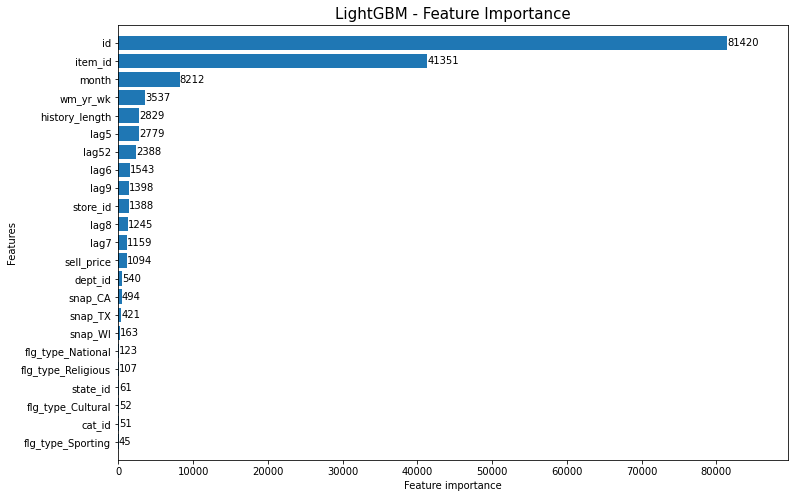

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [27]:
# calculate weekly seasonaly per month
sales

,id,qty,lag5,lag6,lag7,lag8,lag9,lag52,wm_yr_wk,snap_CA,...,flg_type_Sporting,month,year,item_id,dept_id,cat_id,store_id,state_id,sell_price,history_length
52,0,3,25,8,11,14,7,3,11152,0,...,0,1,2012,0,0,0,0,0,2.00,364
53,0,5,5,25,8,11,14,9,11201,3,...,0,1,2012,0,0,0,0,0,2.00,371
54,0,6,5,5,25,8,11,7,11202,7,...,1,2,2012,0,0,0,0,0,2.00,378
55,0,5,3,5,5,25,8,8,11203,0,...,0,2,2012,0,0,0,0,0,2.00,385
56,0,6,8,3,5,5,25,14,11204,0,...,0,2,2012,0,0,0,0,0,2.00,392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8506705,30489,0,0,1,1,1,0,1,11613,0,...,0,4,2016,3048,6,2,9,2,5.94,1911
8506706,30489,0,0,0,1,1,1,1,11614,6,...,0,4,2016,3048,6,2,9,2,5.94,1918
8506707,30489,0,0,0,0,1,1,0,11615,4,...,0,5,2016,3048,6,2,9,2,5.94,1925
8506708,30489,0,0,0,0,0,1,2,11616,0,...,0,5,2016,3048,6,2,9,2,5.94,1932
